# parse_data_config()解析coco.data文件

In [5]:
def load_classes(path):
    """
    Loads class labels at 'path'
    """
    fp = open(path, 'r')
    names = fp.read().split('\n')
    return list(filter(None, names))  # filter removes empty strings (such as last line)
path=r'/py/jupyter-notebook/yolov3-master/data/coco.names'
print(load_classes(path))

def parse_data_config(path):
    """Parses the data configuration file"""
    options = dict()
    options['gpus'] = '0,1,2,3'
    options['num_workers'] = '10'
    with open(path, 'r') as fp:
        lines = fp.readlines()
    for line in lines:
        line = line.strip()
        if line == '' or line.startswith('#'):
            continue
        key, value = line.split('=')
        options[key.strip()] = value.strip()
    return options
path=r'/py/jupyter-notebook/yolov3-master/cfg/coco.data'
parse_data_config(path)


['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


{'backup': 'backup/',
 'classes': '80',
 'eval': 'coco',
 'gpus': '0,1,2,3',
 'names': 'data/coco.names',
 'num_workers': '10',
 'train': '../coco/trainvalno5k.txt',
 'valid': '../coco/5k.txt'}

# class load_images()加载图片 

In [7]:
#part1
import glob
import math
import os
import numpy as np
import cv2
#首先是文件夹读取，返回包含所有文件路径的列表
path = r'/py'
files = sorted(glob.glob('%s/*.*' % path))
print('part1:\n',files,'\n')

#part2
#图片填充方式,运行可以看到结果
#def resize_square(img, height=416, color=(0, 0, 0)):
print('\npart2:shown in next block')
height = 416
color = (127.5, 127.5, 127.5)
path = r'/py/pic/133.jpg'
img = cv2.imread(path)
shape = img.shape[:2]
ratio = float(height) / max(shape)
# print('shape:{}'.format(shape))
new_shape = [round(shape[0] * ratio), round(shape[1] * ratio)]
# print('new_shape:{}'.format(new_shape))
dw = height - new_shape[1]
dh = height - new_shape[0]
# print('dw:{0}\ndh:{1}'.format(dw,dh))
top, bottom = dh // 2, dh - (dh // 2)
left, right = dw // 2, dw - (dw // 2)
# print('top:{0},bottom:{1}\nleft:{2},right:{3}'.format(top,bottom,left,right))
img = cv2.resize(
    img, (new_shape[1], new_shape[0]), interpolation=cv2.INTER_AREA)
img = cv2.copyMakeBorder(
    img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
#显示部分，取消注释即可输出填充图片
cv2.imshow('pic',img)
cv2.waitKey(0)


#part3
# Normalize RGB
'''
1.通过索引[:, :, ::-1]进行bgr->rgb的翻转
2.通过transpose(2, 0, 1)进行轴的翻转：(h,w,c)->(c,w,h)
3.(个人理解)通过np.ascontiguousarray返回array形式的浮点数组
'''
print('\npart3:')
print('raw_img：{}'.format(img.shape))
img = img[:, :, ::-1]
print('1st_trans_img：{}'.format(img.shape))
img = img.transpose(2, 0, 1)
print('2rd_trans_img：{}'.format(img.shape))
# print(img)
img = np.ascontiguousarray(img, dtype=np.float32)
# print(img)


#part4
#类方法理解
class load_images():
    def __init__(self, path, batch_size=1, img_size=416):
        if os.path.isdir(path):
            self.files = sorted(glob.glob('%s/*.*' % path))
        elif os.path.isfile(path):
            self.files = [path]
        self.nF = len(self.files)
        self.nB = math.ceil(self.nF / batch_size)
        self.batch_size = batch_size
        self.height = img_size

    '''
    迭代器方法，需要定义__iter__和__next__，前者是创建迭代器可以理解为迭代器的初始化，后者是每次迭代执行的操作
    __next__：索引从0开始，一旦超出nB(batch数目)就抛出异常，停止迭代；每次迭代返回图片路径列表和像素矩阵
    __len__：定义len()方法，调用len()时会返回nB
    '''

    def __iter__(self):
        self.count = -1
        return self

    def __next__(self):
        self.count += 1
        if self.count == self.nB:
            raise StopIteration
        img_path = self.files[self.count]
        img = cv2.imread(img_path)
        #删掉归一化和padding了方便阅读,但是维度和尺寸我还是自己改了
        return [img_path], img

    def __len__(self):
        return self.nB  # number of batches

images_path = r'/py/pic/JPEGImages'  #30张图片
batch_size = 2
img_size = 416
dataloader = load_images(images_path, batch_size=batch_size, img_size=img_size)
print('\npart4:\n')
for i, (img_paths, img) in enumerate(dataloader):
    #调用len()方法，返回batch数，相当于可视化过程
    print('%g/%g' % (i + 1, len(dataloader)), end=' ')

part1:
 ['/py/cv.py', '/py/data_partition.py', '/py/img_filter.py', '/py/img_format_trans.py', '/py/qt.py', '/py/readtxt.py', '/py/tf.py', '/py/txt2voc.py'] 


part2:shown in next block

part3:
raw_img：(416, 416, 3)
1st_trans_img：(416, 416, 3)
2rd_trans_img：(3, 416, 416)

part4:

1/15 2/15 3/15 4/15 5/15 6/15 7/15 8/15 9/15 10/15 11/15 12/15 13/15 14/15 15/15 

填充后的图片：
长边缩放到416，短边保持比例缩放，然后图片扩为416*416，图片在中间，不足部分灰度填充
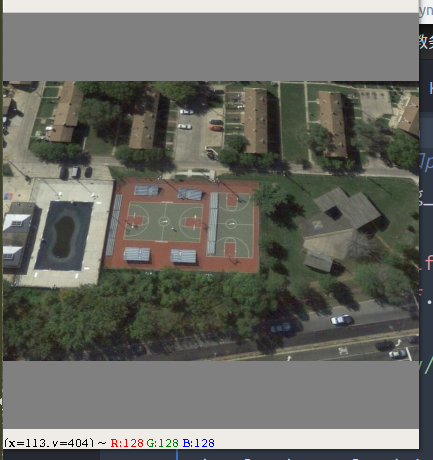

# for i, (module_def, module) in enumerate(zip(module_defs, module_list)):遍历的到底是什么（直接看结论）

In [2]:
import torch
import random
import numpy as np
import torch.nn as nn
class EmptyLayer(nn.Module):
    """Placeholder for 'route' and 'shortcut' layers"""
    #为shortcut layer / route layer 准备, 具体功能不在此实现，在Darknet类的forward函数中有体现
    def __init__(self):
        super(EmptyLayer, self).__init__()
class YOLOLayer(nn.Module):

    def __init__(self, anchors, nC, img_dim, anchor_idxs):         #YOLOLayer实例化需要传入的参数：anchors, num_classes, img_height, anchor_idxs, cfg=hyperparams['cfg']
        super(YOLOLayer, self).__init__()

        anchors = [(a_w, a_h) for a_w, a_h in anchors]  # (pixels)      #anchors不变，还是列表嵌套三个元组，但是将宽高提取赋值给了a_w和a_h
        nA = len(anchors)

        self.anchors = anchors
        self.nA = nA                                                    # number of anchors (3)
        self.nC = nC                                                    # number of classes (80)
        self.bbox_attrs = 5 + nC                                        #每个box的回归的属性值数目4+1+class
        self.img_dim = img_dim                                          # from hyperparams in cfg file, NOT from parser
        
        #降采样步长，同时也是对应原图每个grid cell的尺寸！后面会用
        if anchor_idxs[0] == (nA * 2):  #6                              # anchor_idxs[0]可能值为0,3,6
            stride = 32                                                 #检测13*13特征图，降采样步长32
        elif anchor_idxs[0] == nA:  # 3
            stride = 16                                                 #检测26*26特征图，降采样步长16
        else:
            stride = 8                                                  #检测52*52特征图，降采样步长8

        nG = int(self.img_dim / stride)                                 #便于对特征图编号
        self.grid_x = torch.arange(nG).repeat(nG, 1).view([1, 1, nG, nG]).float()
        self.grid_y = torch.arange(nG).repeat(nG, 1).t().view([1, 1, nG, nG]).float()
        self.scaled_anchors = torch.FloatTensor([(a_w / stride, a_h / stride) for a_w, a_h in anchors])
        self.anchor_w = self.scaled_anchors[:, 0:1].view((1, nA, 1, 1)) #将anchow的w，按照grid cell的尺寸进行缩小归一化处理
        self.anchor_h = self.scaled_anchors[:, 1:2].view((1, nA, 1, 1))
        self.weights = class_weights()                                  #统计了coco的80类gt出现的归一化比重作为权值

        self.loss_means = torch.ones(6)                                 #6维行向量，用1初始化
        self.tx, self.ty, self.tw, self.th = [], [], [], []             #存储box回归定位信息（sigmoid归一化后的）
        self.yolo_layer = anchor_idxs[0] / nA                           # 2, 1, 0

    def forward(self, p, targets=None, batch_report=False, var=None):
        FT = torch.cuda.FloatTensor if p.is_cuda else torch.FloatTensor
        bs = p.shape[0]  # batch size
        nG = p.shape[2]  # number of grid points

        if p.is_cuda and not self.grid_x.is_cuda:
            self.grid_x, self.grid_y = self.grid_x.cuda(), self.grid_y.cuda()
            self.anchor_w, self.anchor_h = self.anchor_w.cuda(), self.anchor_h.cuda()
            self.weights, self.loss_means = self.weights.cuda(), self.loss_means.cuda()

        # p.view(12, 255, 13, 13) -- > (12, 3, 13, 13, 80)  # (bs, anchors, grid, grid, classes + xywh)
        p = p.view(bs, self.nA, self.bbox_attrs, nG, nG).permute(0, 1, 3, 4, 2).contiguous()  # prediction

        # Training
        if targets is not None:
            MSELoss = nn.MSELoss()
            BCEWithLogitsLoss = nn.BCEWithLogitsLoss()
            CrossEntropyLoss = nn.CrossEntropyLoss()

            # Get outputs
            x = torch.sigmoid(p[..., 0])  # Center x
            y = torch.sigmoid(p[..., 1])  # Center y
            p_conf = p[..., 4]  # Conf
            p_cls = p[..., 5:]  # Class

            # Width and height (yolo method)
            w = p[..., 2]  # Width
            h = p[..., 3]  # Height
            width = torch.exp(w.data) * self.anchor_w
            height = torch.exp(h.data) * self.anchor_h

            # Width and height (power method)
            # w = torch.sigmoid(p[..., 2])  # Width
            # h = torch.sigmoid(p[..., 3])  # Height
            # width = ((w.data * 2) ** 2) * self.anchor_w
            # height = ((h.data * 2) ** 2) * self.anchor_h

            p_boxes = None
            if batch_report:
                # Predicted boxes: add offset and scale with anchors (in grid space, i.e. 0-13)
                gx = x.data + self.grid_x[:, :, :nG, :nG]
                gy = y.data + self.grid_y[:, :, :nG, :nG]
                p_boxes = torch.stack((gx - width / 2,
                                       gy - height / 2,
                                       gx + width / 2,
                                       gy + height / 2), 4)  # x1y1x2y2

            tx, ty, tw, th, mask, tcls, TP, FP, FN, TC = \
                build_targets(p_boxes, p_conf, p_cls, targets, self.scaled_anchors, self.nA, self.nC, nG, batch_report)

            tcls = tcls[mask]
            if x.is_cuda:
                tx, ty, tw, th, mask, tcls = tx.cuda(), ty.cuda(), tw.cuda(), th.cuda(), mask.cuda(), tcls.cuda()

            # Compute losses
            nT = sum([len(x) for x in targets])  # number of targets
            nM = mask.sum().float()  # number of anchors (assigned to targets)
            nB = len(targets)  # batch size
            k = nM / nB
            if nM > 0:
                lx = k * MSELoss(x[mask], tx[mask])
                ly = k * MSELoss(y[mask], ty[mask])
                lw = k * MSELoss(w[mask], tw[mask])
                lh = k * MSELoss(h[mask], th[mask])

                # self.tx.extend(tx[mask].data.numpy())
                # self.ty.extend(ty[mask].data.numpy())
                # self.tw.extend(tw[mask].data.numpy())
                # self.th.extend(th[mask].data.numpy())
                # print([np.mean(self.tx), np.std(self.tx)],[np.mean(self.ty), np.std(self.ty)],[np.mean(self.tw), np.std(self.tw)],[np.mean(self.th), np.std(self.th)])
                # [0.5040668, 0.2885492] [0.51384246, 0.28328574] [-0.4754091, 0.57951087] [-0.25998235, 0.44858757]
                # [0.50184494, 0.2858976] [0.51747805, 0.2896323] [0.12962963, 0.6263085] [-0.2722081, 0.61574113]
                # [0.5032071, 0.28825334] [0.5063132, 0.2808862] [0.21124361, 0.44760725] [0.35445485, 0.6427766]
                # import matplotlib.pyplot as plt
                # plt.hist(self.x)

                # lconf = k * BCEWithLogitsLoss(p_conf[mask], mask[mask].float())

                lcls = (k / 4) * CrossEntropyLoss(p_cls[mask], torch.argmax(tcls, 1))
                # lcls = (k * 10) * BCEWithLogitsLoss(p_cls[mask], tcls.float())
            else:
                lx, ly, lw, lh, lcls, lconf = FT([0]), FT([0]), FT([0]), FT([0]), FT([0]), FT([0])

            # lconf += k * BCEWithLogitsLoss(p_conf[~mask], mask[~mask].float())
            lconf = (k * 64) * BCEWithLogitsLoss(p_conf, mask.float())

            # Sum loss components
            balance_losses_flag = False
            if balance_losses_flag:
                k = 1 / self.loss_means.clone()
                loss = (lx * k[0] + ly * k[1] + lw * k[2] + lh * k[3] + lconf * k[4] + lcls * k[5]) / k.mean()

                self.loss_means = self.loss_means * 0.99 + \
                                  FT([lx.data, ly.data, lw.data, lh.data, lconf.data, lcls.data]) * 0.01
            else:
                loss = lx + ly + lw + lh + lconf + lcls

            # Sum False Positives from unassigned anchors
            FPe = torch.zeros(self.nC)
            if batch_report:
                i = torch.sigmoid(p_conf[~mask]) > 0.5
                if i.sum() > 0:
                    FP_classes = torch.argmax(p_cls[~mask][i], 1)
                    FPe = torch.bincount(FP_classes, minlength=self.nC).float().cpu()  # extra FPs

            return loss, loss.item(), lx.item(), ly.item(), lw.item(), lh.item(), lconf.item(), lcls.item(), \
                   nT, TP, FP, FPe, FN, TC

        else:
            stride = self.img_dim / nG
            p[..., 0] = torch.sigmoid(p[..., 0]) + self.grid_x  # x
            p[..., 1] = torch.sigmoid(p[..., 1]) + self.grid_y  # y
            p[..., 2] = torch.exp(p[..., 2]) * self.anchor_w  # width
            p[..., 3] = torch.exp(p[..., 3]) * self.anchor_h  # height
            p[..., 4] = torch.sigmoid(p[..., 4])  # p_conf
            p[..., :4] *= stride

            # reshape from [1, 3, 13, 13, 85] to [1, 507, 85]
            return p.view(bs, self.nA * nG * nG, 5 + self.nC)
def parse_model_config(path):
    """Parses the yolo-v3 layer configuration file and returns module definitions"""
    file = open(path, 'r')
    lines = file.read().split('\n')
    lines = [x for x in lines if x and not x.startswith('#')]
    lines = [x.rstrip().lstrip() for x in lines] # get rid of fringe whitespaces
    module_defs = []
    for line in lines:
        if line.startswith('['): # This marks the start of a new block
            module_defs.append({})
            module_defs[-1]['type'] = line[1:-1].rstrip()
            if module_defs[-1]['type'] == 'convolutional':
                module_defs[-1]['batch_normalize'] = 0
        else:
            key, value = line.split("=")
            value = value.strip()
            module_defs[-1][key.rstrip()] = value.strip()

    return module_defs
def create_modules(module_defs):
    hyperparams = module_defs.pop(0)
    output_filters = [int(hyperparams['channels'])]
    module_list = nn.ModuleList()
    for i, module_def in enumerate(module_defs):
        modules = nn.Sequential()

        if module_def['type'] == 'convolutional':
            bn = int(module_def['batch_normalize'])
            filters = int(module_def['filters'])
            kernel_size = int(module_def['size'])
            pad = (kernel_size - 1) // 2 if int(module_def['pad']) else 0
            modules.add_module('conv_%d' % i, nn.Conv2d(in_channels=output_filters[-1],
                                                        out_channels=filters,
                                                        kernel_size=kernel_size,
                                                        stride=int(module_def['stride']),
                                                        padding=pad,
                                                        bias=not bn))
            if bn:
                modules.add_module('batch_norm_%d' % i, nn.BatchNorm2d(filters))
            if module_def['activation'] == 'leaky':
                modules.add_module('leaky_%d' % i, nn.LeakyReLU(0.1))

        elif module_def['type'] == 'yolo':
            modules.add_module('yolo_%d' % i, EmptyLayer())

        elif module_def['type'] == 'upsample':
            modules.add_module('upsample_%d' % i, EmptyLayer())

        elif module_def['type'] == 'route':
            layers = [int(x) for x in module_def['layers'].split(',')]
            filters = sum([output_filters[i + 1 if i > 0 else i] for i in layers])
            modules.add_module('route_%d' % i, EmptyLayer())

        elif module_def['type'] == 'shortcut':
            filters = output_filters[int(module_def['from'])]
            modules.add_module('shortcut_%d' % i, EmptyLayer())
        module_list.append(modules)
        output_filters.append(filters)

    return hyperparams, module_list
'''
我把层定义和搭建挪过来了，但是YOLO层和Upsample层是自定义的，觉得太麻烦了，就用EmptyLayer代替
'''
path=r'/py/jupyter-notebook/yolov3-master/cfg/yolov3.cfg'
module_defs=parse_model_config(path)
hyperparams, module_list = create_modules(module_defs)
'''下两个循环仅供打印阅读之用'''
for i, (module_def, module) in enumerate(zip(module_defs, module_list)):
    print ('module_def:{}\n'.format(module_def))
print('\n\n\n')
for i, (module_def, module) in enumerate(zip(module_defs, module_list)):
    print ('module:{}'.format(module))


module_def:{'type': 'convolutional', 'batch_normalize': '1', 'filters': '32', 'size': '3', 'stride': '1', 'pad': '1', 'activation': 'leaky'}

module_def:{'type': 'convolutional', 'batch_normalize': '1', 'filters': '64', 'size': '3', 'stride': '2', 'pad': '1', 'activation': 'leaky'}

module_def:{'type': 'convolutional', 'batch_normalize': '1', 'filters': '32', 'size': '1', 'stride': '1', 'pad': '1', 'activation': 'leaky'}

module_def:{'type': 'convolutional', 'batch_normalize': '1', 'filters': '64', 'size': '3', 'stride': '1', 'pad': '1', 'activation': 'leaky'}

module_def:{'type': 'shortcut', 'from': '-3', 'activation': 'linear'}

module_def:{'type': 'convolutional', 'batch_normalize': '1', 'filters': '128', 'size': '3', 'stride': '2', 'pad': '1', 'activation': 'leaky'}

module_def:{'type': 'convolutional', 'batch_normalize': '1', 'filters': '64', 'size': '1', 'stride': '1', 'pad': '1', 'activation': 'leaky'}

module_def:{'type': 'convolutional', 'batch_normalize': '1', 'filters': '128

# NMS非极大值抑制

In [ ]:
'''
展示效果：以自己的图片组为输入查看中间结果变化
输出说明：NMS输出往往对于一个标签不止一个，很好理解，因为NMS是为了剔除高重合度的复检框，而最后多输出box重合度不高，说明待检测的目标在图片中不止一次出现
（因此，减小NMS阈值便于密集目标检测，允许更多重叠框，但是误检概率也提高了，反之亦可推）
'''
def non_max_suppression(prediction, conf_thres=0.5, nms_thres=0.4):
    '''
    prediction.shape为torch.Size([1, 65, 85])，输入时第0维扩充了维度
    '''
    output = [None for _ in range(len(prediction))]

    for image_i, pred in enumerate(prediction):
    '''
    pred.shape为torch.Size([65, 85]) 65为box数目，85为4+1+80
    '''

        x, y, w, h = pred[:, 0], pred[:, 1], pred[:, 2], pred[:, 3]
        a = w * h  
        ar = w / (h + 1e-16)  
        log_w, log_h, log_a, log_ar = torch.log(w), torch.log(h), torch.log(a), torch.log(ar)

        '''
        截出所有box的类概率（index=5开始，coco=80）softmax处理
        torch.max(a,n)返回第 n维度的最大值及其索引！这里是返回第一维度的最大值和其索引，也就是对应的类概率最大值和其属于哪一类
        '''
        class_prob, class_pred = torch.max(F.softmax(pred[:, 5:], 1), 1)
        '''
        每个张量都是一维65个，对应65个box，反映了每个box最可能属于哪一类，只分析这一个，其他的舍弃
        我用的图片都是车，索引索引集中在少数几个标签很正常
        (tensor([0.99933, 0.99817, 0.99711, 0.86205, 0.99938, 0.99935,
        0.57333, 0.49102, 0.99997, 0.60971, 0.66674, 0.98297, 0.99998,
        0.99967, 0.99995, 0.98533, 0.81239, 0.91213, 0.99993, 0.99996, 
        0.99958, 0.58524, 0.99986, 0.99961, 0.99978, 0.99803, 0.99943, 
        0.99998, 0.99989, 0.99963, 0.99788, 0.99985, 0.99997, 0.97002, 
        0.99998, 0.99952, 0.85971, 0.99995, 0.95171, 0.97362, 0.99468, 
        0.76785, 0.99996, 0.99894, 0.99980, 0.99991, 0.99991, 0.99979, 
        0.99993, 0.99941, 0.99995, 0.99982, 0.99966, 1.00000, 0.61127, 
        0.99999, 0.88204, 0.90181, 0.99985, 0.99956, 0.99983, 0.99980, 
        0.99976, 0.99991, 0.99985], device='cuda:0'), 
        
        tensor([5, 5, 5, 7, 7, 7, 2, 2, 2, 2, 7, 2, 2, 2, 2, 2, 2, 2, 
        5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
        2, 2, 5, 2, 2, 2, 2, 7, 7, 2, 7, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
        2, 2, 2, 2, 2], device='cuda:0'))

        '''
        
        v = ((pred[:, 4] > conf_thres) & (class_prob > .3))
        '''
        对上面的每个的最大可能概率分析，返回是否满足两个阈值条件的bool量矩阵
        （我用的都是车，挺好检验，所以65个全满足）
         tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1], device='cuda:0', dtype=torch.uint8)
        '''
        v = v.nonzero().squeeze()
        '''
        v.nonzero()是返回bool矩阵的真值下标;.squeeze()是去除一维的维度比如a=torch.rand(3,1,4),a.copy().squeeze().shape为（3,4）[注意浅拷贝深拷贝]
        tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 
        14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
        30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 
        46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 
        62, 63, 64], device='cuda:0')
        '''
        if len(v.shape) == 0:
            v = v.unsqueeze(0)
        '''返回满足条件的box及其最大概率和最大概率所属的类'''
        pred = pred[v] 
        class_prob = class_prob[v]
        class_pred = class_pred[v]

        # If none are remaining => process next image
        nP = pred.shape[0]
        if not nP:
            continue

        # From (center x, center y, width, height) to (x1, y1, x2, y2)
        pred[:, :4] = xywh2xyxy(pred[:, :4])

        # Detections ordered as (x1, y1, x2, y2, obj_conf, class_prob, class_pred)
        '''
        通过torch.cat（（a,b,c）,1）按照第1维度融合，其他维度（box数目）不变
        第0维度不变仍然是box数目，第一通道的纵深：(x1, y1, x2, y2, obj_conf, class_prob, class_pred)
        即尺寸为： detections：torch.Size([65, 7])
        （主要是类概率选择，将原来的85信息压缩到有用的7信息）
        '''
        detections = torch.cat((pred[:, :5], class_prob.float().unsqueeze(1), class_pred.float().unsqueeze(1)), 1)
        # Iterate through all predicted classes
        '''
        unique()返回无重复的列表/张量
        detections[:, -1].cpu().unique() 就是返回了类别索引
        tensor([2., 7., 5.])得到类别标签
        '''
        unique_labels = detections[:, -1].cpu().unique()
        if prediction.is_cuda:
            unique_labels = unique_labels.cuda(prediction.device)

        nms_style = 'OR'  # 'AND' or 'OR' (classical)
        for c in unique_labels:
            # Get the detections with the particular class
            '''遍历类标签，detections_class是所有最大类概率为标签c的box'''
            detections_class = detections[detections[:, -1] == c]
            # Sort the detections by maximum objectness confidence
            '''
            1.torch.sort对所有box按照confidence进行降序排序，返回重新排序后的元素在原来张量的索引
            （torch.sort（）按给定轴（没给就是最后一个轴）默认升序排列，返回两项：重排后的张量，和重排后元素在原张量的索引）
            2.注意：这里是浅拷贝，detections_class本身元素的顺序没有改变
            3.本部分最后得到detections_class是confidence按照降序排列的box矩阵
            4.如自己的图片，第一个标签是2（car）,只比较检测最大概率标签为2的，其detections_class尺寸为torch.Size([52, 7])
            
            如：我将单个循环的c和排序后detections_class的confidence提取出来：
            tensor(2., device='cuda:0')#第一个标签2
                tensor([0.99877, 0.99727, 0.99722, 0.99656, 0.99289, 0.99112, 0.99081, 0.98410, 0.98084, 
                0.97983, 0.97976, 0.97232, 0.96795, 0.96715, 0.94664, 0.91381, 0.90831, 0.90287, 0.90199, 
                0.89786, 0.89770, 0.89167, 0.88462, 0.88012, 0.87393, 0.84077, 0.81373, 0.80814, 0.80010, 
                0.78308, 0.76594, 0.76478, 0.73337, 0.71944, 0.70404, 0.70003, 0.69284, 0.68182, 0.66471,
                0.61649, 0.60716, 0.59777, 0.59286, 0.58664, 0.58514, 0.57180, 0.56679, 0.53148, 0.52819, 
                0.51561, 0.51350, 0.50555], device='cuda:0')
            tensor(7., device='cuda:0')#第二个标签7
                tensor([0.99225, 0.98947, 0.97814, 0.93893, 0.77212, 0.70385, 0.65959], device='cuda:0')
            tensor(5., device='cuda:0')#第三个标签5
                tensor([0.99779, 0.99367, 0.97964, 0.87668, 0.85198, 0.69522], device='cuda:0')

            '''
            _, conf_sort_index = torch.sort(detections_class[:, 4], descending=True)
            detections_class = detections_class[conf_sort_index]
            # Perform non-maximum suppression
            max_detections = []  '''每次重置，存放当前遍历标签下经过nms后仍存留的box'''
            '''
            经典NMS从最大confidence的box作为起点，第一步NMS抑制后，留下重合度不高的box;
            第二步从上面被留下来的box（不含起点最大conf的box，那个已经被保存在max_detections了），选一个最大的confidence再次作为起点，对其他的进行NMS，并将起点box放入max_detections
            循环往复直到候选框为0;
            所以NMS后输出可能不止一个
            '''
            if nms_style == 'OR':  # Classical NMS
                while detections_class.shape[0]:   '''还存在满足阈值的box'''
                    # Get detection with highest confidence and save as max detection
                    '''
                    detections_class[0]是当前标签c中的最大confidence对应的box信息（7个），添加到max_detections，并加一维
                    (atten)之所以加维度，是为了concat!直接看后面if len(max_detections) > 0:语句处解释
                    '''
                    max_detections.append(detections_class[0].unsqueeze(0))
                    # Stop if we're at the last detection
                    if len(detections_class) == 1:
                        break           '''只有一个box就不用抑制了'''
                    # Get the IOUs for all boxes with lower confidence
                    '''
                    1.bbox_iou()接受两种模式的box坐标输入，默认是对角坐标，就如这里
                    2.max_detections存放各标签最大confidence的box信息（7个见上面分析），-1是当前标签
                    3.将最大的confidence与剩下的其他box进行iou计算
                    4.返回box_num-1长度的一维张量
                    '''
                    ious = bbox_iou(max_detections[-1], detections_class[1:])

                    # Remove detections with IoU >= NMS threshold
                    '''
                    作用：移除大于thres的box，因为相似度太高，抑制非极大值，减少重复框
                    detections_class[1:]  除了第一个外（当前最大confidence是iou计算的标杆），剩下的进行比较；
                                          detections_class = detections_class[1:]直接覆盖，在保持原来排序的基础下，将第一个值detections_class.shape[0]更换为第一个比较框外的最大概率box，很精巧
                    不断循环直到没有候选框detections_class.shape[0]=0跳出
                    
                    如：此处筛选之后detections_class的尺度为torch.Size([50, 7])还剩下50个候选框
                    '''
                    detections_class = detections_class[1:][ious < nms_thres]

            elif nms_style == 'AND':  # 'AND'-style NMS, at least two boxes must share commonality to pass, single boxes erased
                while detections_class.shape[0]:
                    if len(detections_class) == 1:
                        break

                    ious = bbox_iou(detections_class[:1], detections_class[1:])

                    if ious.max() > 0.5:
                        max_detections.append(detections_class[0].unsqueeze(0))

                    # Remove detections with IoU >= NMS threshold
                    detections_class = detections_class[1:][ious < nms_thres]

            if len(max_detections) > 0:
                '''
                max_detections是一个列表，内嵌每次NMS添加的box张量，每个张量都是维度扩充后的shape为（1,7），如下：
                    [tensor([[ 79.72221, 222.52879, 120.57208, 252.33409,   0.99877,   0.99985,   2.00000]], device='cuda:0'),
                    tensor([[294.39301, 193.77907, 324.32056, 214.71013,   0.99727,   0.99982,   2.00000]], device='cuda:0'), 
                    ...]
                那么经过torch.cat()默认按照0维融合，可以生成二维的矩阵如下：
                tensor([[ 79.72221, 222.52879, 120.57208, 252.33409,   0.99877,   0.99985,   2.00000],
                        [294.39301, 193.77907, 324.32056, 214.71013,   0.99727,   0.99982,   2.00000],
                        [  2.10991, 302.13052,  79.07612, 346.37070,   0.99722,   0.99995,   2.00000],
                        [151.14726, 202.77879, 180.22389, 227.34428,   0.99656,   1.00000,   2.00000],..., device='cuda:0') 
                维度增加是为了便于cat融合得到二维矩阵
                '''
                max_detections = torch.cat(max_detections).data
                # Add max detections to outputs
                output[image_i] = max_detections if output[image_i] is None else torch.cat(
                    (output[image_i], max_detections))
    '''
    最终得到所有标签的列表，内嵌张量，如下：
    [tensor([[ 79.72221, 222.52879, 120.57208, 252.33409,   0.99877,   0.99985,   2.00000],
            ...
            [321.93240, 206.89230, 365.30844, 244.60419,   0.99225,   0.66674,   7.00000],
            ...
            [197.32550, 129.58583, 224.19870, 148.87822,   0.87668,   0.76785,   5.00000]], 
            device='cuda:0')]
    '''
    
    return output

'''
atten注：这样通过unqueeze()再cat便于索引，
例如：       
a=torch.Tensor([[1,2,3,4]])
b=torch.Tensor([[6,7,8,9]])
torch.cat((a,b),0)
输出：         
tensor([[1., 2., 3., 4.],
       [6., 7., 8., 9.]])
如果不加维，直接cat融合如：
a=torch.Tensor([1,2,3,4])
b=torch.Tensor([6,7,8,9])
torch.cat((a,b),0)
输出：
tensor([1., 2., 3., 4., 6., 7., 8., 9.])显然索引不方便
'''

# zip()创建迭代器

In [ ]:
zip可以很好地压缩融合不同结构的数据，从而为迭代遍历创造很便捷的操作，分析如下。

for img_i, (path, detections) in enumerate(zip(imgs, img_detections)):
        print("image %g: '%s'" % (img_i, path))

该代码段的zip(imgs, img_detections)为亮点，
imgs是所有图片的路径列表，打印如：
    ['data/samples/18.jpg', 'data/samples/2.jpg', 'data/samples/27.jpg', 'data/samples/29.jpg', 
     'data/samples/30.jpg','data/samples/4.jpg', 'data/samples/6.jpg', 'data/samples/zidane.jpg']
img_detections是每张图回归及NMS处理后按标签&置信度排序的列表，内嵌box张量,打印如下：
    [tensor([[ 79.72221, 222.52879, 120.57208, 252.33409,   0.99877,   0.99985,   2.00000],#第一张图的box
             [294.39301, 193.77907, 324.32056, 214.71013,   0.99727,   0.99982,   2.00000],
             ...
             [199.52783, 145.47101, 228.03259, 194.97580,   0.65959,   0.86205,   7.00000],
             ...
             [197.32550, 129.58583, 224.19870, 148.87822,   0.87668,   0.76785,   5.00000]], device='cuda:0'), 
     tensor([[356.82690, 242.11752, 415.54230, 314.15042,   0.98662,   0.88756,   5.00000],#第二张图的box
             ...], device='cuda:0'),
     ...
    ]

下面我们zip()一下，打印zip(imgs, img_detections),神奇的事情出现了：
[('data/samples/18.jpg', tensor([[ 79.72221, 222.52879, 120.57208, 252.33409,   0.99877,   0.99985,   2.00000],
                                 [294.39301, 193.77907, 324.32056, 214.71013,   0.99727,   0.99982,   2.00000],
                                 [  2.10991, 302.13052,  79.07612, 346.37070,   0.99722,   0.99995,   2.00000],
                                 ...
                                 [197.32550, 129.58583, 224.19870, 148.87822,   0.87668,   0.76785,   5.00000]], device='cuda:0')),,
 #第一个打包的元组完毕，下面依次如此
 ...
]
每张图片路径和其回归的box进行了完美的组合，从而可以统一迭代


# box绘制和文本显示

In [ ]:
'''
这个代码标签框的绘制十分不走心，不好看自己改吧
keras的qwe大神自己设置的字体哦
'''
def plot_one_box(x, img, color=None, label=None, line_thickness=None):  # Plots one bounding box on image img
    '''x实际传递的是向量，列表形式的[x1, y1, x2, y2];label是一个字符窜，内含类别和置信度信息'''
    
    '''(可改）线条宽度默认为2,整数输入（如果是-1代表填充）'''
    tl = line_thickness or round(0.002 * max(img.shape[0:2])) + 1  # line thickness
    '''如果不指定color，每个box颜色都不一样，花花绿绿的'''
    color = color or [random.randint(0, 255) for _ in range(3)] 
    '''c1,c2分别是左上和右下角的坐标'''
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3])) 
    '''opencv画框，输入线条为整数，一般是2'''
    cv2.rectangle(img, c1, c2, color, thickness=tl)
    if label:
        '''字体粗细这里默认是1（可改）'''
        tf = max(tl - 1, 1)  # font thickness
        '''
        cv2.getTextSize(text, fontFace, fontScale, thickness)函数是获取文本字符的宽高信息的元组和baseline信息（基本尺寸），第零维是宽高元组
        如作者设置的：（(85, 15), 6)，其中标签尺寸给的(85, 15)，baseline为6
        text：要绘制的文本
        fontFace：选用的字体（可改）如cv2.FONT_HERSHEY_SCRIPT_COMPLEX等（搜索OpenCV绘图之字体和文字即可找到）
        fontScale：字体大小因子（乘以字体基础大小，可改）
        thickness：字体粗细
        '''
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        '''计算标签框的位置，对角坐标c1,c2，放到box的左上角，至于这个-3,是为了消除字体宽吧，作者多虑了，去了也无妨'''
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        '''绘制标签，-1表示填充'''
        cv2.rectangle(img, c1, c2, color, -1)  
        '''
        https://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html#void%20putText(Mat&%20img,%20const%20string&%20text,%20Point%20org,%20int%20fontFace,%20double%20fontScale,%20Scalar%20color,%20int%20thickness,%20int%20lineType,%20bool%20bottomLeftOrigin)
        设置文本函数原型为：cv2.putText(img, text, org, fontFace, fontScale, color[, thickness[, lineType[, bottomLeftOrigin]]]) 
        org：左下角的坐标元组
        color:建议黑的[0,0,0]比白的好看
        thickness输入还是  整数
        '''
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)